In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [316]:
df = pd.read_csv('../data/raw/clinical_data_lung.zip')

In [317]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [318]:
df.columns

Index(['Age recode with <1 year olds and 90+',
       'Race recode (White, Black, Other)', 'Primary Site - labeled',
       'Histologic Type ICD-O-3', 'Grade Clinical (2018+)',
       'Grade Recode (thru 2017)',
       'Combined Summary Stage with Expanded Regional Codes (2004+)',
       'Derived EOD 2018 Stage Group Recode (2018+)',
       '7th Edition Stage Group Recode (2016-2017)',
       'Derived AJCC Stage Group, 7th ed (2010-2015)',
       'CS tumor size (2004-2015)', 'Tumor Size Summary (2016+)',
       'Survival months', 'Survival months flag',
       'Vital status recode (study cutoff used)',
       'SEER cause-specific death classification', 'Year of diagnosis',
       'Median household income inflation adj to 2023',
       'RX Summ--Surg Prim Site (1998+)', 'Radiation recode',
       'Chemotherapy recode (yes, no/unk)', 'Sex',
       'Rural-Urban Continuum Code', 'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Tota

In [319]:
df["Survival months flag"].value_counts()

Survival months flag
Complete dates are available and there are more than 0 days of survival      514829
Not calculated because a Death Certificate Only or Autopsy Only case          13051
Incomplete dates are available and there cannot be zero days of follow-up      6503
Complete dates are available and there are 0 days of survival                  2092
Incomplete dates are available and there could be zero days of follow-up        943
Name: count, dtype: int64

In [320]:
df["Survival months"].value_counts()

Survival months
0000       59494
0001       43733
0002       32276
0003       24324
0004       20581
0005       17296
0006       16703
0007       14956
0008       13747
0009       13412
Unknown    13051
0010       11773
0011       11040
0012        9906
0013        9378
0014        8581
0016        7774
0015        7772
0017        6990
0018        6957
0019        6229
0020        6148
0021        5570
0022        5307
0023        4897
0024        4763
0025        4506
0027        4433
0026        4299
0028        3945
0029        3930
0030        3743
0034        3464
0033        3383
0035        3242
0036        3154
0031        3150
0038        3107
0032        2971
0037        2914
0041        2836
0039        2761
0040        2731
0042        2593
0043        2563
0045        2510
0044        2499
0046        2367
0047        2268
0050        2160
0052        2131
0049        2129
0048        2119
0054        1940
0056        1899
0053        1891
0051        1888
0055        182

# Analisis de variables

# 1. Variables Demográficas y Socioeconómicas

## Eliminacion de columnas que no son de valor significativo

In [321]:
columns_to_drop = ["Type of Reporting Source", 
                   "Grade Clinical (2018+)",
                   "Sequence number",
                   "Primary Site"]
#df = df.drop(columns=columns_to_drop)

#### Observaciones:
> - `Race and origin (recommended by SEER)` se elimina debido a que es una etiqueta general.
> - `Type of Reporting Source` se elimina debido a la dominancia excesiva de (Hospital inpatient/outpatient or clinic) y categorías minoritarias como (Autopsy only) con apenas 454 registros.
> - `Diagnostic Confirmation`  una vez limpio el conjunto de datos de estos registros no validados por diagnósticos se elimina la columna.
> - `Origin recode NHIA (Hispanic, Non-Hisp)`  Esa informacion solo contiene 2 tipos de caracteristicas prenominando una de ellas con mas del 90% de los datos
> - `PRCDA 2020` Indirectamente, PRCDA suele estar asociada a zonas más rurales o comunidades específicas, Esta variable está fuertemente ligada a la raza (American Indian/Alaska Native), al tener una variable que ya nos clasifica las razas esta no es necesaria
> - `Primary Site` existe otra variable que tambien refleja donde comenzo a crecer el tumor  

In [322]:
df.columns

Index(['Age recode with <1 year olds and 90+',
       'Race recode (White, Black, Other)', 'Primary Site - labeled',
       'Histologic Type ICD-O-3', 'Grade Clinical (2018+)',
       'Grade Recode (thru 2017)',
       'Combined Summary Stage with Expanded Regional Codes (2004+)',
       'Derived EOD 2018 Stage Group Recode (2018+)',
       '7th Edition Stage Group Recode (2016-2017)',
       'Derived AJCC Stage Group, 7th ed (2010-2015)',
       'CS tumor size (2004-2015)', 'Tumor Size Summary (2016+)',
       'Survival months', 'Survival months flag',
       'Vital status recode (study cutoff used)',
       'SEER cause-specific death classification', 'Year of diagnosis',
       'Median household income inflation adj to 2023',
       'RX Summ--Surg Prim Site (1998+)', 'Radiation recode',
       'Chemotherapy recode (yes, no/unk)', 'Sex',
       'Rural-Urban Continuum Code', 'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Tota

## Age 

In [323]:
df.groupby("Age recode with <1 year olds and 90+")["Vital status recode (study cutoff used)"].value_counts().unstack().fillna(0)

Vital status recode (study cutoff used),Alive,Dead
Age recode with <1 year olds and 90+,,
00 years,19,1
01-04 years,32,5
05-09 years,14,3
10-14 years,28,7
15-19 years,68,17
20-24 years,141,55
25-29 years,246,129
30-34 years,436,318
35-39 years,764,768


se puede observar que las edades estan divididas en en rango de edades de 5 años aproximadamente, se procedera a reagrupar a las personas en grupos mas grandes siguiendo una lógica fisiológica y clínica.
 
Grupo 1 (0-19 años): Pediátrico/Adolescente. Cánceres con biología muy distinta y alta tasa de supervivencia en muchos casos.

Grupo 2 (20-39 años): Adulto Joven. Pacientes con pocas comorbilidades (otras enfermedades) pero donde el cáncer puede ser más agresivo.

Grupo 3 (40-59 años): Adulto Medio. La etapa donde aumenta la incidencia; es el "estándar" del dataset.

Grupo 4 (60-75 años): Adulto Mayor. Comienzan a aparecer otros problemas de salud que afectan el tratamiento.

Grupo 5 (>75 años): Gerátrico. El riesgo de mortalidad no relacionada con el cáncer es muy alto y los tratamientos suelen ser menos invasivos.

In [324]:
# agregar una columna de grupo de edades 

# 1. Definimos los rangos para cada grupo
grupo_1 = ['00 years', '01-04 years', '05-09 years', '10-14 years', '15-19 years']
grupo_2 = ['20-24 years', '25-29 years', '30-34 years', '35-39 years']
grupo_3 = ['40-44 years','45-49 years', '50-54 years', '55-59 years']
grupo_4 =['60-64 years','65-69 years', '70-74 years']
# El resto (65+) caerá en el grupo 5

# 2. Función lógica para asignar el grupo
def asignar_grupo(edad):
    if edad in grupo_1: return 1
    if edad in grupo_2: return 2
    if edad in grupo_3: return 3
    if edad in grupo_4: return 4
    return 5  # Todo lo que no esté en los anteriores (80+)

# 3. Creamos la columna
df['age_group'] = df['Age recode with <1 year olds and 90+'].apply(asignar_grupo)

# 4. Verificamos los conteos
df['age_group'].value_counts().sort_index()

age_group
1       194
2      2857
3     79595
4    256857
5    197915
Name: count, dtype: int64

al tener una nueva columna con las edades divididas en grupos no necesitamos la anterior por tal motivo procedemos a eliminarla

In [325]:
# Eliminamos la columna original de edad
df.drop('Age recode with <1 year olds and 90+', axis=1, inplace=True)

## sex

In [326]:
df.groupby("Sex")["Vital status recode (study cutoff used)"].value_counts().unstack().fillna(0)

Vital status recode (study cutoff used),Alive,Dead
Sex,,
Female,83863,179031
Male,64223,210301


## Race recode (White, Black, Other)

In [327]:
# cambiar el nombre de la columna a Race
df.rename(columns={'Race recode (White, Black, Other)': 'Race'}, inplace=True)

df["Race"].value_counts()



Race
White                                                        434822
Black                                                         57145
Other (American Indian/AK Native, Asian/Pacific Islander)     43620
Unknown                                                        1831
Name: count, dtype: int64

Se observan 4 tipos de caracteristicas, agruparemos  las caracteristicas de Other con Unknown en una sola caracteristica "Other"

In [328]:
# Definimos la lista de las categorías que queremos agrupar
a_renombrar = ['Other (American Indian/AK Native, Asian/Pacific Islander)', 'Unknown']

# Reemplazamos esos valores por 'Other'
df['Race'] = df['Race'].replace(a_renombrar, 'Other')

In [329]:
df.groupby("Race")["Vital status recode (study cutoff used)"].value_counts().unstack().fillna(0)

Vital status recode (study cutoff used),Alive,Dead
Race,,
Black,14496,42649
Other,15910,29541
White,117680,317142


## 'Rural-Urban Continuum Code'

In [330]:
df['Rural-Urban Continuum Code'].value_counts().sort_index()

Rural-Urban Continuum Code
Counties in metropolitan areas ge 1 million pop                 291753
Counties in metropolitan areas of 250,000 to 1 million pop      113711
Counties in metropolitan areas of lt 250 thousand pop            46491
Nonmetropolitan counties adjacent to a metropolitan area         49586
Nonmetropolitan counties not adjacent to a metropolitan area     35039
Unknown/missing/no match (Alaska or Hawaii - Entire State)         821
Unknown/missing/no match/Not 1990-2023                              17
Name: count, dtype: int64

In [331]:
df.groupby("Rural-Urban Continuum Code")["Vital status recode (study cutoff used)"].value_counts().unstack().fillna(0)

Vital status recode (study cutoff used),Alive,Dead
Rural-Urban Continuum Code,,
Counties in metropolitan areas ge 1 million pop,86580,205173
"Counties in metropolitan areas of 250,000 to 1 million pop",31083,82628
Counties in metropolitan areas of lt 250 thousand pop,11186,35305
Nonmetropolitan counties adjacent to a metropolitan area,11885,37701
Nonmetropolitan counties not adjacent to a metropolitan area,7174,27865
Unknown/missing/no match (Alaska or Hawaii - Entire State),171,650
Unknown/missing/no match/Not 1990-2023,7,10


podemos observar que las dos clasificaciones desconocidas ademas de tener pocos datos no se consideran muy relevantes el porcentaje de personas vivas al final de  la ultima fecha de estudio por tal motivo procederan a eliminarse y tambien cambiaremos el nombre de la columna a "Rural Code"

In [332]:
df.rename(columns={'Rural-Urban Continuum Code': 'Rural Code'}, inplace=True)

# 1. características a eliminar
a_eliminar = ['Unknown/missing/no match (Alaska or Hawaii - Entire State)', 'Unknown/missing/no match/Not 1990-2023']

# 2. Sobreescribimos el dataframe filtrando: "Manten los que NO estén en la lista"
df = df[~df['Rural Code'].isin(a_eliminar)]

In [333]:
df['Rural Code'].value_counts()

Rural Code
Counties in metropolitan areas ge 1 million pop                 291753
Counties in metropolitan areas of 250,000 to 1 million pop      113711
Nonmetropolitan counties adjacent to a metropolitan area         49586
Counties in metropolitan areas of lt 250 thousand pop            46491
Nonmetropolitan counties not adjacent to a metropolitan area     35039
Name: count, dtype: int64

## Median household income inflation adj to 2023

In [334]:
df[ 'Median household income inflation adj to 2023'].unique()


array(['$120,000+', '$110,000 - $119,999', '$100,000 - $109,999',
       '$95,000 - $99,999', '$90,000 - $94,999', '$85,000 - $89,999',
       '$80,000 - $84,999', '$75,000 - $79,999', '$70,000 - $74,999',
       '$65,000 - $69,999', '$60,000 - $64,999', '$55,000 - $59,999',
       '$50,000 - $54,999', '$45,000 - $49,999', '< $40,000',
       '$40,000 - $44,999'], dtype=object)

Propuesta de Reagrupación Óptima

Dividiremos los ingresos basándonos en la distribución típica de niveles de vida (Bajo, Medio-Bajo, Medio, Medio-Alto, Alto):

Grupo 1: Nivel Bajo (Menos de $45k) Representa a la población con mayores barreras económicas.

Grupo 2: Nivel Medio-Bajo ($45k - $64k)

Grupo 3: Nivel Medio ($65k - $84k)

Grupo 4: Nivel Medio-Alto ($85k - $109k)

Grupo 5: Nivel Alto (Más de $110k)

Incluye: $110,000 - $119,999 y $120,000+.

In [335]:
# Usaremos un diccionario de mapeo para asegurar que cada string se convierta exactamente en el número del grupo.

# Definimos el mapeo manual para asegurar precisión
map_ingresos = {
    '< $40,000': 1, '$40,000 - $44,999': 1,
    '$45,000 - $49,999': 2, '$50,000 - $54,999': 2, '$55,000 - $59,999': 2, '$60,000 - $64,999': 2,
    '$65,000 - $69,999': 3, '$70,000 - $74,999': 3, '$75,000 - $79,999': 3, '$80,000 - $84,999': 3,
    '$85,000 - $89,999': 4, '$90,000 - $94,999': 4, '$95,000 - $99,999': 4, '$100,000 - $109,999': 4,
    '$110,000 - $119,999': 5, '$120,000+': 5
}

# Creamos la nueva columna
df['income_level'] = df['Median household income inflation adj to 2023'].map(map_ingresos)


df.groupby("income_level")["Vital status recode (study cutoff used)"].value_counts().unstack().fillna(0)


Vital status recode (study cutoff used),Alive,Dead
income_level,,
1,3669,17841
2,23520,90097
3,45847,140737
4,50161,100229
5,24711,39768


In [336]:
# Eliminamos la columna original de nivel de ingresos
df.drop('Median household income inflation adj to 2023', axis=1, inplace=True)

## SEER cause-specific death classification

In [337]:
# 1. características a eliminar
df = df[df['SEER cause-specific death classification'] != "Dead (missing/unknown COD)"]

aqui tenemos tres tipos de clasificaciones:
personas muertas debido al  cancer, personas vivas o muertas por causas distintas a las del cancer y personas que han muerto pero la razon del fallecimiento es desconocida, para un mejor modelo e importante tener casos en los que son claros los fallecimientos, por tal motivo los casos en donde se desconoce la razon de muerte seran eliminados

In [338]:
# 1. características a eliminar
df = df.drop("Vital status recode (study cutoff used)", axis=1)

# Definimos el mapeo según tus instrucciones
mapeo_muerte = {
    'Dead (attributable to this cancer dx)': 'dead',
    'Alive or dead of other cause': 'Alive'
}

# Aplicamos el cambio
df['SEER cause-specific death classification'] = df['SEER cause-specific death classification'].map(mapeo_muerte)

# Verificamos el resultado final
print("Nuevas etiquetas de la variable:")
print(df['SEER cause-specific death classification'].value_counts())

Nuevas etiquetas de la variable:
SEER cause-specific death classification
dead     313070
Alive    219796
Name: count, dtype: int64


aqui podemos observar que entre las dos columnas que tenemos, la columna Vital status recode (study cutoff used) nos introduce ruido al modelo ya que solo clasifica a las personas por muertas y vivas por tal  motivo, nos quedaremos solo con las variables que nos separan a las personas por causas de muerte debido al cancer

una persona que ha muerto por causas ajenas al cancer (accidente u otra enfermedad) se puede considerar como viva al momento del ultimo seguimiento ya que su muerte no ha sido debido a la enfermedad del cancer por lo cual no se puede descartar que un tratamiento u operacion hubiese sido beneficioso.

Renombramos las caracteristicas de la clasificacion y el nombre de la  columna

In [339]:
# renombramos la columna
df.rename(columns={'SEER cause-specific death classification': 'vital_status'}, inplace=True)

In [340]:

# 1. Aseguramos que sea entero
df['survival_months_int'] = pd.to_numeric(df['Survival months'], errors='coerce').fillna(0).astype(int)

# 2. Definir la nueva función con rangos mixtos (de 5 en 5 y luego de 10 en 10)
def agrupar_supervivencia_ajustado(meses):
    if meses == 0:
        return 0
    elif 1 <= meses <= 6:
        return 6
    elif 6 < meses <= 54:
        # Incrementos de 5 en 5 hasta los 5 años
        return int(np.ceil(meses / 6.0) * 6)
    else:
        # Más de 60 meses (más de 5 años)
        return 60

# 3. Aplicamos la transformación
df['survival_range'] = df['survival_months_int'].apply(agrupar_supervivencia_ajustado)

# 4. Verificación para confirmar los saltos que pediste
print("Rangos de supervivencia generados:")
print(sorted(df['survival_range'].unique()))

print("\nConteo por rango:")
print(df['survival_range'].value_counts().sort_index())

Rangos de supervivencia generados:
[np.int64(0), np.int64(6), np.int64(12), np.int64(18), np.int64(24), np.int64(30), np.int64(36), np.int64(42), np.int64(48), np.int64(54), np.int64(60)]

Conteo por rango:
survival_range
0      72028
6     153553
12     74083
18     46971
24     32611
30     24615
36     19190
42     16824
48     14210
54     12044
60     66737
Name: count, dtype: int64


In [341]:
# Definimos las dos condiciones
condicion_dead = (df['vital_status'] == 'dead')
condicion_alive_largo = (df['vital_status'] == 'Alive') & (df['survival_range'] >= 60)

# Unimos ambas con el operador OR (|)
df_filtrado = df[condicion_dead | condicion_alive_largo]

# Verificamos
print(f"Total después del filtro: {len(df_filtrado)}")
print(df_filtrado['vital_status'].value_counts())

Total después del filtro: 369657
vital_status
dead     313070
Alive     56587
Name: count, dtype: int64


In [342]:
df = df.drop("Survival months", axis=1)

# 2. Variables del Tumor (Biología y Localización)

## Primary Site - labeled

In [343]:
df["Primary Site - labeled"].value_counts()

Primary Site - labeled
C34.1-Upper lobe, lung              261982
C34.3-Lower lobe, lung              139705
C34.9-Lung, NOS                      82324
C34.2-Middle lobe, lung              23000
C34.0-Main bronchus                  20714
C34.8-Overlapping lesion of lung      5141
Name: count, dtype: int64

Indica en qué parte específica del pulmón se originó el tumor.

C34.1, C34.2, C34.3: Lóbulos superior, medio e inferior. Es vital para la supervivencia; los tumores en el lóbulo superior a veces tienen pronósticos distintos por la cercanía a grandes vasos.

C34.0 (Main bronchus): El bronquio principal. Suele ser más central y difícil de operar.

C34.9 (Lung, NOS): "Not Otherwise Specified". Significa que en la historia clínica solo dice "pulmón" sin aclarar el lóbulo.

C34.8 (Overlapping lesion): El tumor es tan grande que abarca más de un lóbulo.

Dado que la clasificacion "C34.9-Lung NOS" no nos devuelve informacion sobre donde se encuentra el tomor se hace dificil tomar decisiones sobre como enfrentar a ese tumor ya que no se sabe la gravedad del mismo, por tal motivo esta clasificación crea ruido para futuras predicciones del modelo.

In [344]:
# 1. Filtramos: Nos quedamos con todas las filas donde el valor NO SEA 'C34.9-Lung, NOS'
df = df[df['Primary Site - labeled'] != 'C34.9-Lung, NOS']

# 2. Reiniciamos los índices para eliminar los huecos de las filas borradas
df = df.reset_index(drop=True)

df['Primary Site - labeled'].value_counts()

Primary Site - labeled
C34.1-Upper lobe, lung              261982
C34.3-Lower lobe, lung              139705
C34.2-Middle lobe, lung              23000
C34.0-Main bronchus                  20714
C34.8-Overlapping lesion of lung      5141
Name: count, dtype: int64

In [345]:
df.rename(columns={'Primary Site - labeled': 'Primary Site'}, inplace=True)

## Histologic Type ICD-O-3 

In [346]:
df["Histologic Type ICD-O-3"].unique()


array([8140, 8550, 8070, 8000, 8041, 8046, 8240, 8010, 8560, 8246, 8255,
       8551, 8012, 8254, 8252, 8230, 8480, 8073, 8071, 8260, 8250, 8022,
       8072, 8033, 8980, 8430, 8032, 8265, 8249, 8481, 8020, 8253, 8310,
       8043, 8083, 8507, 8800, 8013, 8200, 8244, 9120, 9041, 8323, 8082,
       8490, 8045, 8144, 8802, 8890, 8044, 8574, 8256, 8042, 8123, 8031,
       8084, 8830, 9040, 8973, 8004, 8251, 8052, 8075, 8575, 8074, 8470,
       9064, 8933, 8001, 8050, 9133, 8333, 9540, 8805, 8005, 9043, 8680,
       8801, 8023, 8825, 8257, 9080, 8341, 8576, 8940, 8900, 8720, 8021,
       8815, 8891, 8014, 8030, 8245, 8972, 8581, 8290, 8714, 9071, 9100,
       8441, 8562, 8810, 8120, 8201, 9180, 8811, 8803, 9473, 9044, 8854,
       9260, 8211, 8982, 8920, 8570, 8500, 8440, 8002, 8901, 8247, 8410,
       8580, 8051, 8912, 8896, 9070, 9364, 8963, 8850, 8894, 8510, 9015,
       8804, 9220, 8094, 9240, 8584, 8320, 9130, 8040, 8210, 8743, 9137,
       9370, 8806, 8035, 8003, 8078, 9561, 8936, 87

se pueden observar los códigos de Morfología de la patología los cuales se agruparan en las grandes familias del cáncer de pulmón. la reagrupación a usar:

Adenocarcinomas (Los más comunes): Códigos que empiezan por 814, 825, 826, 831, 848, 855.

Carcinomas de Células Escamosas (Epidermoides): Códigos que empiezan por 807, 808.

Células Pequeñas (Small Cell - El más agresivo): Códigos 8041, 8042, 8043, 8044, 8045.

Células Grandes (Large Cell): Códigos 8012, 8013, 8014.

Tumores Neuroendocrinos / Carcinoides: Códigos 8240, 8246, 8249.

Otros / Sarcomatoides / No Especificados: Todo lo demás (códigos 8000, 8800, etc.)

In [347]:
def agrupar_histologia_codigo(codigo):
    c = int(codigo)
    # 1. Células Pequeñas (Small Cell - Muy agresivo)
    if c in [8041, 8042, 8043, 8044, 8045]:
        return "Small Cell Carcinoma"
    # 2. Adenocarcinomas
    elif (8140 <= c <= 8149) or (8250 <= c <= 8260) or (8480 <= c <= 8490) or (c == 8550):
        return "Adenocarcinoma"
    # 3. Células Escamosas (Squamous)
    elif 8070 <= c <= 8084:
        return "Squamous Cell Carcinoma"
    # 4. Células Grandes (Large Cell)
    elif 8012 <= c <= 8014:
        return "Large Cell Carcinoma"
    # 5. Neuroendocrinos / Carcinoides
    elif 8240 <= c <= 8249:
        return "Neuroendocrine Tumors"
    # 6. Otros o No Especificados
    else:
        return "Other/NOS"

# Aplicamos la función para crear una columna de texto
df['histology_type_named'] = df['Histologic Type ICD-O-3'].apply(agrupar_histologia_codigo)

# Verificamos los nombres
print(df['histology_type_named'].value_counts())

histology_type_named
Adenocarcinoma             197538
Squamous Cell Carcinoma     99207
Other/NOS                   86174
Small Cell Carcinoma        47872
Neuroendocrine Tumors       14755
Large Cell Carcinoma         4996
Name: count, dtype: int64


In [348]:
# Eliminamos la columna original de los codigos.
df.drop("Histologic Type ICD-O-3", axis=1, inplace=True)

## CS tumor size (2004-2015) y Tumor Size Summary (2016+)

En los datasets oncológicos (como SEER), los valores 990-999 suelen ser códigos de error o "tamaño desconocido". Vamos a eliminarlos para que no arruinen tu escala numérica.

Para predecir meses de vida, necesitamos más detalle que el "Pequeño/Mediano/Grande". Usaremos una escala basada en el sistema TNM (8va Edición), que es el estándar de oro médico.

Rango (mm),Categoría,Por qué es útil para el modelo

0 - 10,      Micro/T1a,Supervivencia muy alta

11 - 20,     T1b,Localizado

21 - 30,     T2a,Empieza a afectar pronóstico

31 - 50,     T2b,Riesgo moderado

51 - 70,     T3,Riesgo alto

mayor a 70,        T4,Afectación severa / Supervivencia baja

In [349]:
df['CS tumor size (2004-2015)'] = pd.to_numeric(df['CS tumor size (2004-2015)'], errors='coerce')
df['Tumor Size Summary (2016+)'] = pd.to_numeric(df['Tumor Size Summary (2016+)'], errors='coerce')

# Limpiamos códigos de 'desconocido' (típicamente >= 990 en registros médicos)
df.loc[df['Tumor Size Summary (2016+)'] >= 990, 'Tumor Size Summary (2016+)'] = np.nan
df.loc[df['CS tumor size (2004-2015)'] >= 990, 'CS tumor size (2004-2015)'] = np.nan


# Creamos la columna unificada tomando el valor disponible (o el máximo si están ambos)
df['tumor_size'] = df[['Tumor Size Summary (2016+)', 'CS tumor size (2004-2015)']].max(axis=1)

# IMPORTANTE: Para ML, eliminamos las filas donde el tamaño es desconocido
df = df.dropna(subset=['tumor_size'])

In [350]:
# Definimos los cortes (bins) y las etiquetas
# El 900 es el límite superior común en milímetros para registros médicos
bins = [-1, 10, 20, 30, 50, 70, 990] 
labels = [10, 20, 30, 50, 70, 100]

df['tumor_category'] = pd.cut(df['tumor_size'], bins=bins, labels=labels)

In [351]:
df['tumor_category'].value_counts().sort_index()

tumor_category
10      19686
20      85030
30      77572
50     103554
70      60506
100     54151
Name: count, dtype: int64

In [352]:
#eliminamos las columnas de tamaño anteriores
df.drop(["tumor_size", "Tumor Size Summary (2016+)", "CS tumor size (2004-2015)"], axis=1, inplace=True)

## Total number of in situ/malignant tumors for patient

In [353]:
df['Total number of in situ/malignant tumors for patient'].value_counts()

Total number of in situ/malignant tumors for patient
1     269175
2      94201
3      27418
4       7216
5       1782
6        481
7        146
8         33
9         19
10         9
11         6
13         2
21         2
32         2
14         2
30         2
34         1
18         1
23         1
Name: count, dtype: int64

en vista de que a partir de un total de 6 tumores cancerigenos disminuye una gran cantidad de personas que tienen ese numero de tumores o mayores colocaremos todos esos registros registros en una categoria 5

In [354]:
df['Total number of in situ/malignant tumors for patient'] = df['Total number of in situ/malignant tumors for patient'].clip(upper=5)

In [355]:
df['Total number of in situ/malignant tumors for patient'].value_counts()

Total number of in situ/malignant tumors for patient
1    269175
2     94201
3     27418
4      7216
5      2489
Name: count, dtype: int64

## Total number of benign/borderline tumors for patient

In [356]:
df['Total number of benign/borderline tumors for patient'].value_counts()

Total number of benign/borderline tumors for patient
0    395465
1      4869
2       156
3         8
4         1
Name: count, dtype: int64

aqui podemos observar que la mayoria de las personas poseen tumores cancerigenos malignos. Valdria la pena incluir esta variable en nuestros datoss? ya que los tumores  benignos no son causantes de riesgos mortales

# Estadificación (Severidad y Extensión)

## Year of diagnosis

In [357]:
df["Year of diagnosis"].value_counts().sort_index

<bound method Series.sort_index of Year of diagnosis
2019    38203
2017    38064
2018    37504
2021    37336
2022    37186
2016    36776
2015    36466
2014    35598
2013    34652
2020    34450
2012    34264
Name: count, dtype: int64>

aqui podemos observar que desde el 2012 al 2022 se han diagnosticado entre 34.000 y 39.000 cancer de pulmon por año, valdria  la pena observar si con años mas recientes de diagnostico las personas alcanzan mas meses de sobrevivencia del cancer e incluso lograr vencerlos

## Combined Summary Stage with Expanded Regional Codes (2004+)

In [358]:
df["Combined Summary Stage with Expanded Regional Codes (2004+)"].value_counts().sort_index()

Combined Summary Stage with Expanded Regional Codes (2004+)
Distant site(s)/node(s) involved                                181401
In situ                                                              3
Localized only                                                  120142
Regional by both direct extension and lymph node involvement     25817
Regional by direct extension only                                31769
Regional lymph nodes involved only                               38404
Unknown/unstaged/unspecified/DCO                                  2963
Name: count, dtype: int64

In [359]:
# Definimos exactamente el nombre de la categoría que quieres analizar
target_stage = "Unknown/unstaged/unspecified/DCO"

# Creamos un sub-dataset solo con esos casos
df_unknown = df[df["Combined Summary Stage with Expanded Regional Codes (2004+)"] == target_stage]

# Vemos el conteo de cuántos pacientes en ese estado tienen cada rango de tamaño
conteo_por_rango = df_unknown['tumor_category'].value_counts()

print(f"Distribución de Tumor Size para el estadio: {target_stage}")
print(conteo_por_rango)

Distribución de Tumor Size para el estadio: Unknown/unstaged/unspecified/DCO
tumor_category
50     787
20     621
30     578
70     422
100    387
10     168
Name: count, dtype: int64


al observar la distribucion de los tamaños de los tumores en la clasificacion Unknown/unstaged/unspecified/DCO no predominan las categorias con tamaños mas grandes con las cuales se pudiese pensar que no se ha podido determinar el lugar de crecimiento por tal motivo estos datos podrian generar ruidos por el cual seran eliminados 

In [360]:
df = df[df["Combined Summary Stage with Expanded Regional Codes (2004+)"] !=  "Unknown/unstaged/unspecified/DCO"]

## RX Summ--Surg Prim Site (1998+)

In [361]:
df["RX Summ--Surg Prim Site (1998+)"].value_counts().sort_index()


RX Summ--Surg Prim Site (1998+)
0     290362
12       656
13       205
15       258
19       134
20       372
21     18308
22      6000
23       524
24       287
25       118
30      8454
33     65281
45      1833
46       726
47        78
48        66
55       560
56      2035
65        27
66        33
70        55
80        75
90       394
99       695
Name: count, dtype: int64

Esta variable es fundamental porque indica el tipo de tratamiento quirúrgico que recibió el paciente en el sitio primario del tumor. En los datasets tipo SEER, los códigos suelen ir del 00 al 90, donde los numeros indican

90: Desconocido. No hay registro de si se operó o no.

99: DCO / Autopsia. Casos donde solo se supo del cáncer tras la muerte.

estos datos  no son utiles para realizar el modelo ya que no sabemos con certeza que tipo de tratamiento recibio la persona y una persona a la cual se le diagnostica el cancer por medio de una Autopsia tampoco nos genera valores para un modelo confiable.

In [362]:
# Eliminamos las filas con 90, 99 y también los NaN que pudieron surgir
# Aseguramos que sea numérico
col_surg = "RX Summ--Surg Prim Site (1998+)"
df[col_surg] = pd.to_numeric(df[col_surg], errors='coerce')

# Eliminamos las filas con 90, 99 y también los NaN que pudieron surgir
df = df[~df[col_surg].isin([90, 99])]
df = df.dropna(subset=[col_surg])

In [363]:
# 80: Cirugía, NOS. Se sabe que hubo cirugía, pero el reporte no especifica de qué tipo.

# DEBERIAMOS ELIMINARLA? sirve para decir que pasa si se opera perono que tipo de cirujia

In [364]:
def agrupar_cirugia_pulmon(codigo):
    if codigo == 0:
        return 'no intervenido'  # No intervenido
    elif 10 <= codigo <= 19:
        return 'Cirugía local / Biopsia' 
    elif 20 <= codigo <= 25:
        return 'Escisión local / Resección en cuña' 
    elif codigo == 30:
        return 'Resección segmentaria'    
    elif (codigo == 33) or (45 <= codigo <= 56):
        return 'Lobectomía' 
    elif (codigo == 55) or (codigo == 56):
        return 'Bilobectomía.'
    elif (codigo == 65) or (codigo == 66):
        return 'Neumonectomía' 
    elif (codigo == 70):
        return 'Cirugía extendida' 
    else:
        return 'Otros tipos de cirugía'

df['surgery_class'] = df[col_surg].apply(agrupar_cirugia_pulmon)

In [365]:
df["surgery_class"].value_counts()


surgery_class
no intervenido                        290362
Lobectomía                             70579
Escisión local / Resección en cuña     25609
Resección segmentaria                   8454
Cirugía local / Biopsia                 1253
Otros tipos de cirugía                    75
Neumonectomía                             60
Cirugía extendida                         55
Name: count, dtype: int64

In [366]:
# 3. Eliminamos la columna original
df = df.drop(columns=["RX Summ--Surg Prim Site (1998+)"])

## Type of Reporting Source

In [367]:
df["Type of Reporting Source"].value_counts()

Type of Reporting Source
Hospital inpatient/outpatient or clinic                     386594
Radiation treatment or medical oncology center (2006+)        4104
Other hospital outpatient unit or surgery center (2006+)      4043
Laboratory only (hospital or private)                          732
Physicians office/private medical practitioner (LMD)           726
Autopsy only                                                   184
Nursing/convalescent home/hospice                               64
Name: count, dtype: int64

al igual que en los casos anteriores se esta eliminando casos donde el "Diagnóstico" y la "Muerte" ocurrieron técnicamente al mismo tiempo. Para un modelo de ML que predice supervivencia, esos casos son "ruido" puro, ya que no hubo un seguimiento clínico del paciente vivo

In [368]:
#eliminamos las filas con "Autopsy only"
df = df[df["Type of Reporting Source"] != "Autopsy only"]

finalmente esta variable solo implica somo fue detectado el cancer y tenia sentido mantenerla para eliminar los registros cuyos datos provienen de autopsias, una vez registrados estos datos procedemos a eliminarla

In [369]:
df = df.drop("Type of Reporting Source", axis=1)

## Derived EOD 2018 Stage Group Recode (2018+), 7th Edition Stage Group Recode (2016-2017), Derived AJCC Stage Group, 7th ed (2010-2015)

# 'Combined Summary Stage with Expanded Regional Codes (2004+)'

In [370]:
df['Combined Summary Stage with Expanded Regional Codes (2004+)'].value_counts()


Combined Summary Stage with Expanded Regional Codes (2004+)
Distant site(s)/node(s) involved                                180816
Localized only                                                  119739
Regional lymph nodes involved only                               38266
Regional by direct extension only                                31677
Regional by both direct extension and lymph node involvement     25762
In situ                                                              3
Name: count, dtype: int64

Estas columnas representan el Estadio AJCC (American Joint Committee on Cancer), que es básicamente la "puntuación final" de la gravedad del cáncer.

La razón por la que se tiene tres columnas diferentes es que el sistema médico se actualiza cada pocos años. SEER separa los datos según la "edición" del manual que se usaba en ese momento:

1. ¿Qué significan estos periodos?
2018+ (EOD 2018): Es la versión más moderna. Usa una lógica llamada Extent of Disease.

2016-2017 (7th Edition): Un periodo de transición corto usando la 7ma edición.

2010-2015 (7th ed): La versión consolidada de la 7ma edición.

In [371]:
df["Derived EOD 2018 Stage Group Recode (2018+)"].value_counts().sort_index()
    

Derived EOD 2018 Stage Group Recode (2018+)
0                3
1A1          10356
1A2          21895
1A3          12647
1B           12425
2A            3807
2B           12535
3              695
3A           18346
3B           11821
3C            2773
4             2823
4A           27992
4B           35460
88            8350
99             970
Blank(s)    213365
Name: count, dtype: int64

In [372]:
df['7th Edition Stage Group Recode (2016-2017)'].value_counts().sort_index() 

7th Edition Stage Group Recode (2016-2017)
0                 1
Blank(s)     322454
IA            15713
IB             6451
II               11
IIA            3390
IIB            3176
III             127
IIIA           9982
IIIB           4012
IV            29978
OCCULT           45
UNK Stage       804
Name: count, dtype: int64

In [373]:
df['Derived AJCC Stage Group, 7th ed (2010-2015)'].value_counts().sort_index()

Derived AJCC Stage Group, 7th ed (2010-2015)
Blank(s)     256707
IA            25771
IB            12342
II               32
IIA            6570
IIB            6650
III             496
IIIA          19371
IIIB           8050
IV            59134
UNK Stage       883
Name: count, dtype: int64

In [374]:
def encontrar_columna(lista_cols, palabra_clave):
    for c in lista_cols:
        if palabra_clave in c:
            return c
    return None

cols_actuales = df.columns.tolist()

c1 = encontrar_columna(cols_actuales, 'Combined Summary Stage with Expanded Regional Codes (2004+)')
c2 = encontrar_columna(cols_actuales, 'Derived EOD 2018 Stage Group Recode (2018+)')
c3 = encontrar_columna(cols_actuales, '7th Edition Stage Group Recode (2016-2017)')
c4 = encontrar_columna(cols_actuales, 'Derived AJCC Stage Group, 7th ed (2010-2015)')

stage_cols = [c for c in [c1, c2, c3, c4] if c is not None]

In [375]:
def simplificar_etapa(val):
    val = str(val).upper()
    if any(x in val for x in ['IV', 'DISTANT']): return 'Stage IV'
    if 'III' in val: return 'Stage III'
    if 'II' in val: return 'Stage II'
    if any(x in val for x in ['I', 'LOCALIZED']): return 'Stage I'
    if any(x in val for x in ['0', 'IN SITU']): return 'Stage 0'
    return 'Unknown'

In [376]:
df['Stage_Final'] = df[stage_cols].fillna('').agg(' '.join, axis=1).apply(simplificar_etapa)

In [377]:
df["Stage_Final"].value_counts()

Stage_Final
Stage IV     181021
Stage I      165286
Stage III     30592
Stage II      19364
Name: count, dtype: int64

In [378]:
# 1. Definimos las columnas que queremos ver
columnas_a_eliminar = [
    'Derived EOD 2018 Stage Group Recode (2018+)',
    'Derived AJCC Stage Group, 7th ed (2010-2015)',
    '7th Edition Stage Group Recode (2016-2017)',
    'Combined Summary Stage with Expanded Regional Codes (2004+)'
]

df = df.drop(columns=columnas_a_eliminar)

 ¿Cómo entender los valores?
Aunque los nombres de las columnas cambien, los valores dentro suelen ser los mismos (I, II, III, IV). los cuales tiene como significado:

Estadio 0 (In situ): El cáncer no se ha movido de donde empezó. Supervivencia altísima.

Estadio I: Tumor pequeño y localizado. Pronóstico muy bueno.

Estadio II: El tumor es más grande o ha llegado a ganglios muy cercanos.

Estadio III: El cáncer se ha extendido a tejidos u órganos vecinos o a ganglios linfáticos distantes dentro del pecho. Pronóstico reservado.

Estadio IV (Metastásico): El cáncer se ha propagado a otros órganos (cerebro, huesos, el otro pulmón). Este grupo tendrá la curva de supervivencia más baja en tu modelo.

al revisar los datos podemos observar que la variable Combined Summary Stage with Expanded Regional Codes (2004+) ya tiene estos datos simplificados por lo cual no se procedera a unir estas columnas y seran borradas.

## Grade Clinical (2018+), Grade Recode (thru 2017)

Los datos anteriores a 2017 solían usar una escala de 1 a 4, y a partir de 2018 se volvió más específica, Al igual que con el tamaño del tumor y el estadio, estas columnas representan el mismo concepto médico pero dividido por años de diagnóstico. El Grado (Grade) mide la agresividad biológica de las células cancerosas.

Mientras que el Estadio te dice qué tan lejos ha viajado el cáncer, el Grado te dice qué tan "enojadas" o anormales se ven las células bajo el microscopio.

El grado es un predictor independiente. Esto significa que:

Dos pacientes pueden tener el mismo tamaño de tumor (ej. 30mm). Pero si el Paciente A tiene Grado 1 y el Paciente B tiene Grado 4, el Paciente B tiene una probabilidad mucho más alta de que el cáncer regrese pronto o no responda a la quimioterapia.

In [379]:
df["Grade Clinical (2018+)"].value_counts()

Grade Clinical (2018+)
Blank(s)    213365
9           125915
3            27443
2            19795
1             7863
4             1825
D               26
C               23
B                3
H                3
A                2
Name: count, dtype: int64

##  'Grade Recode (thru 2017)

In [380]:
df["Grade Recode (thru 2017)"].value_counts()

Grade Recode (thru 2017)
Blank(s)                                  182898
Unknown                                   103789
Poorly differentiated; Grade III           50185
Moderately differentiated; Grade II        39919
Well differentiated; Grade I               14524
Undifferentiated; anaplastic; Grade IV      4948
Name: count, dtype: int64

In [381]:

# 2. Normalización básica (quitar espacios en blanco y asegurar que sean strings)
# Esto convierte celdas vacías o con espacios en strings vacíos ''
df['Grade Clinical (2018+)'] = df['Grade Clinical (2018+)'].astype(str).str.strip()
df['Grade Recode (thru 2017)'] = df['Grade Recode (thru 2017)'].astype(str).str.strip()

# 3. Identificamos qué valores consideramos "vacíos" para rellenar
# Reemplazamos 'nan', '' (vacíos) y 'Blank(s)' por el valor de la columna antigua
# PERO dejamos el '9' tranquilo en su lugar.
df['grade_clinical'] = df['Grade Clinical (2018+)'].replace(['nan', '', 'Blank(s)'], np.nan)

# 4. Rellenamos solo esos huecos con la columna 2017
df['grade_clinical'] = df['grade_clinical'].fillna(df['Grade Recode (thru 2017)'])

# 5. Volvemos a limpiar cualquier residuo de la columna vieja
# (por si en la vieja también había 'nan' o 'Blank(s)')
df = df.dropna(subset=['grade_clinical'])


print(df['grade_clinical'].value_counts())

grade_clinical
9                                         125915
Unknown                                   103789
Poorly differentiated; Grade III           50185
Moderately differentiated; Grade II        39919
3                                          27443
2                                          19795
Well differentiated; Grade I               14524
1                                           7863
Undifferentiated; anaplastic; Grade IV      4948
4                                           1825
D                                             26
C                                             23
B                                              3
H                                              3
A                                              2
Name: count, dtype: int64


In [382]:
mapping = {
    # Grupo 1
    'Well differentiated; Grade I': '1', 'A': '1', '1': '1',
    # Grupo 2
    'Moderately differentiated; Grade II': '2', 'B': '2', '2': '2',
    # Grupo 3
    'Poorly differentiated; Grade III': '3', 'C': '3', '3': '3',
    # Grupo 4
    'Undifferentiated; anaplastic; Grade IV': '4', 'D': '4', '4': '4', 'H':'4',
    # Grupo 9
    'Unknown': '9', '9': '9'
}

# 2. Aplicamos el mapeo
# Usamos .map() pero SIN .fillna(9). 
# Esto hará que lo que sea NaN o Blank (y no esté en el diccionario) siga siendo NaN.
df['grade_clinical'] = df['grade_clinical'].map(mapping)

In [383]:
df["grade_clinical"].value_counts()

grade_clinical
9    229704
3     77651
2     59717
1     22389
4      6802
Name: count, dtype: int64

In [384]:
# 3. Eliminamos las columnas originales
df = df.drop(columns=['Grade Clinical (2018+)', 'Grade Recode (thru 2017)'])

# Tratamiento realizado

In [385]:
df['Radiation recode'].value_counts()


Radiation recode
None/Unknown                                             222461
Beam radiation                                           161077
Refused (1988+)                                            7618
Recommended, unknown if administered                       3506
Radiation, NOS  method or source not specified             1033
Radioactive implants (includes brachytherapy) (1988+)       363
Combination of beam with implants or isotopes               110
Radioisotopes (1988+)                                        95
Name: count, dtype: int64

In [386]:

df['Chemotherapy recode (yes, no/unk)'].value_counts()


Chemotherapy recode (yes, no/unk)
No/Unknown    236780
Yes           159483
Name: count, dtype: int64

In [387]:

df['Reason no cancer-directed surgery'].value_counts()


Reason no cancer-directed surgery
Not recommended                                                                 259494
Surgery performed                                                               106085
Not recommended, contraindicated due to other cond; autopsy only (1973-2002)     20886
Recommended but not performed, patient refused                                    6571
Recommended but not performed, unknown reason                                     1658
Recommended, unknown if performed                                                  946
Not performed, patient died prior to recommended surgery                           623
Name: count, dtype: int64

In [388]:
# eliminar los

In [389]:
df["surgery_class"].value_counts()

surgery_class
no intervenido                        290178
Lobectomía                             70579
Escisión local / Resección en cuña     25609
Resección segmentaria                   8454
Cirugía local / Biopsia                 1253
Otros tipos de cirugía                    75
Neumonectomía                             60
Cirugía extendida                         55
Name: count, dtype: int64

In [390]:
df.columns

Index(['Race', 'Primary Site', 'Survival months flag', 'vital_status',
       'Year of diagnosis', 'Radiation recode',
       'Chemotherapy recode (yes, no/unk)', 'Sex', 'Rural Code',
       'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Total number of benign/borderline tumors for patient',
       'Sequence number', 'age_group', 'income_level', 'survival_months_int',
       'survival_range', 'histology_type_named', 'tumor_category',
       'surgery_class', 'Stage_Final', 'grade_clinical'],
      dtype='object')

In [391]:
# df[(df['Reason no cancer-directed surgery'] == "Not recommended") ][["age_group","tumor_category","survival_range", "Chemotherapy recode (yes, no/unk)","Radiation recode", "surgery_class","vital_status"]].value_counts()

In [392]:
df[(df['Reason no cancer-directed surgery'] == "Not recommended") & (df["Radiation recode"] != "None/Unknown") ][["Radiation recode","vital_status"]].value_counts()

Radiation recode                                       vital_status
Beam radiation                                         dead            79694
                                                       Alive           52586
Refused (1988+)                                        dead             3696
Recommended, unknown if administered                   dead             1558
Refused (1988+)                                        Alive             995
Recommended, unknown if administered                   Alive             798
Radiation, NOS  method or source not specified         dead              563
                                                       Alive             299
Radioactive implants (includes brachytherapy) (1988+)  dead              105
                                                       Alive             102
Combination of beam with implants or isotopes          dead               49
Radioisotopes (1988+)                                  dead               38
        

In [393]:
# 1. Estandarizar Cirugía (Usando tus dos columnas de cirugía)
# Si hubo cirugía en 'surgery_class' y se confirmó en 'Reason...', es un SÍ.
df['surg_yesno'] = df.apply(lambda x: 'S' if x['surgery_class'] != 'no intervenido' and x['Reason no cancer-directed surgery'] == 'Surgery performed' else 'N', axis=1)

# 2. Estandarizar Quimioterapia
df['chemo_yesno'] = df['Chemotherapy recode (yes, no/unk)'].map({'Yes': 'Q', 'No/Unknown': 'nQ'})

# 3. Estandarizar Radiación
# Consideramos 'SÍ' a cualquier forma de radiación activa
df['rad_yesno'] = df['Radiation recode'].apply(lambda x: 'R' if x in ['Beam radiation', 'Radioactive implants (includes brachytherapy) (1988+)', 'Combination of beam with implants or isotopes', 'Radioisotopes (1988+)', 'Radiation, NOS  method or source not specified'] else 'nR')

In [394]:
# Creamos la combinación (Ejemplo: S+Q+R significa Cirugía, Quimio y Radio)
df['tratamiento'] = df['surg_yesno'] + " + " + df['chemo_yesno'] + " + " + df['rad_yesno']

# Ejemplo de los nombres que quedarán:
# 'S + Q + R' -> Tratamiento completo
# 'N + nQ + nR' -> Sin tratamiento registrado
# 'S + nQ + nR' -> Solo cirugía

In [395]:
df = df.drop(["surg_yesno","chemo_yesno","rad_yesno"], axis=1)

In [396]:
df["tratamiento"].value_counts()

tratamiento
N + nQ + nR    89303
N + Q + R      83108
S + nQ + nR    76239
N + nQ + R     68822
N + Q + nR     48945
S + Q + nR     19098
S + Q + R       8332
S + nQ + R      2416
Name: count, dtype: int64

In [397]:
df[(df["tratamiento"]!='N + nQ + nR') & (df["vital_status"] == 'Alive')][["survival_range"]].value_counts()

survival_range
60                48936
6                 20918
12                17392
18                14258
24                11916
30                10314
36                 8960
42                 8952
48                 8335
54                 7367
0                  2914
Name: count, dtype: int64

In [398]:
df[(df["tratamiento"]!='N + nQ + nR') & (df["vital_status"] == 'Alive') & (df["survival_range"] >= 60)]["survival_range"].value_counts()

survival_range
60    48936
Name: count, dtype: int64

In [399]:
# Definimos las dos condiciones
condicion_dead = (df['vital_status'] == 'dead')
condicion_alive_largo = (df['vital_status'] == 'Alive') & (df['survival_range'] >= 60)

# Unimos ambas con el operador OR (|)
df_filtrado = df[condicion_dead | condicion_alive_largo]

# Verificamos
print(f"Total después del filtro: {len(df_filtrado)}")
print(df_filtrado['vital_status'].value_counts())

Total después del filtro: 261815
vital_status
dead     210448
Alive     51367
Name: count, dtype: int64


In [400]:
df[["survival_range","vital_status"]].value_counts()

survival_range  vital_status
6               dead            78243
60              Alive           51367
12              dead            37469
6               Alive           28702
0               dead            23152
18              dead            21994
12              Alive           20101
18              Alive           16082
24              dead            13835
                Alive           13236
30              Alive           11325
36              Alive            9772
42              Alive            9657
30              dead             9416
48              Alive            8917
0               Alive            8747
60              dead             8688
54              Alive            7909
36              dead             6536
42              dead             4887
48              dead             3521
54              dead             2707
Name: count, dtype: int64

In [401]:
df.columns

Index(['Race', 'Primary Site', 'Survival months flag', 'vital_status',
       'Year of diagnosis', 'Radiation recode',
       'Chemotherapy recode (yes, no/unk)', 'Sex', 'Rural Code',
       'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Total number of benign/borderline tumors for patient',
       'Sequence number', 'age_group', 'income_level', 'survival_months_int',
       'survival_range', 'histology_type_named', 'tumor_category',
       'surgery_class', 'Stage_Final', 'grade_clinical', 'tratamiento'],
      dtype='object')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3556\4071893136.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='surgery_class', y='survival_range', palette='viridis')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3556\4071893136.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Chemotherapy recode (yes, no/unk)', y='survival_range', palette='magma')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3556\4071893136.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[df['Radiation recode'].isin(top_rad)], x='R

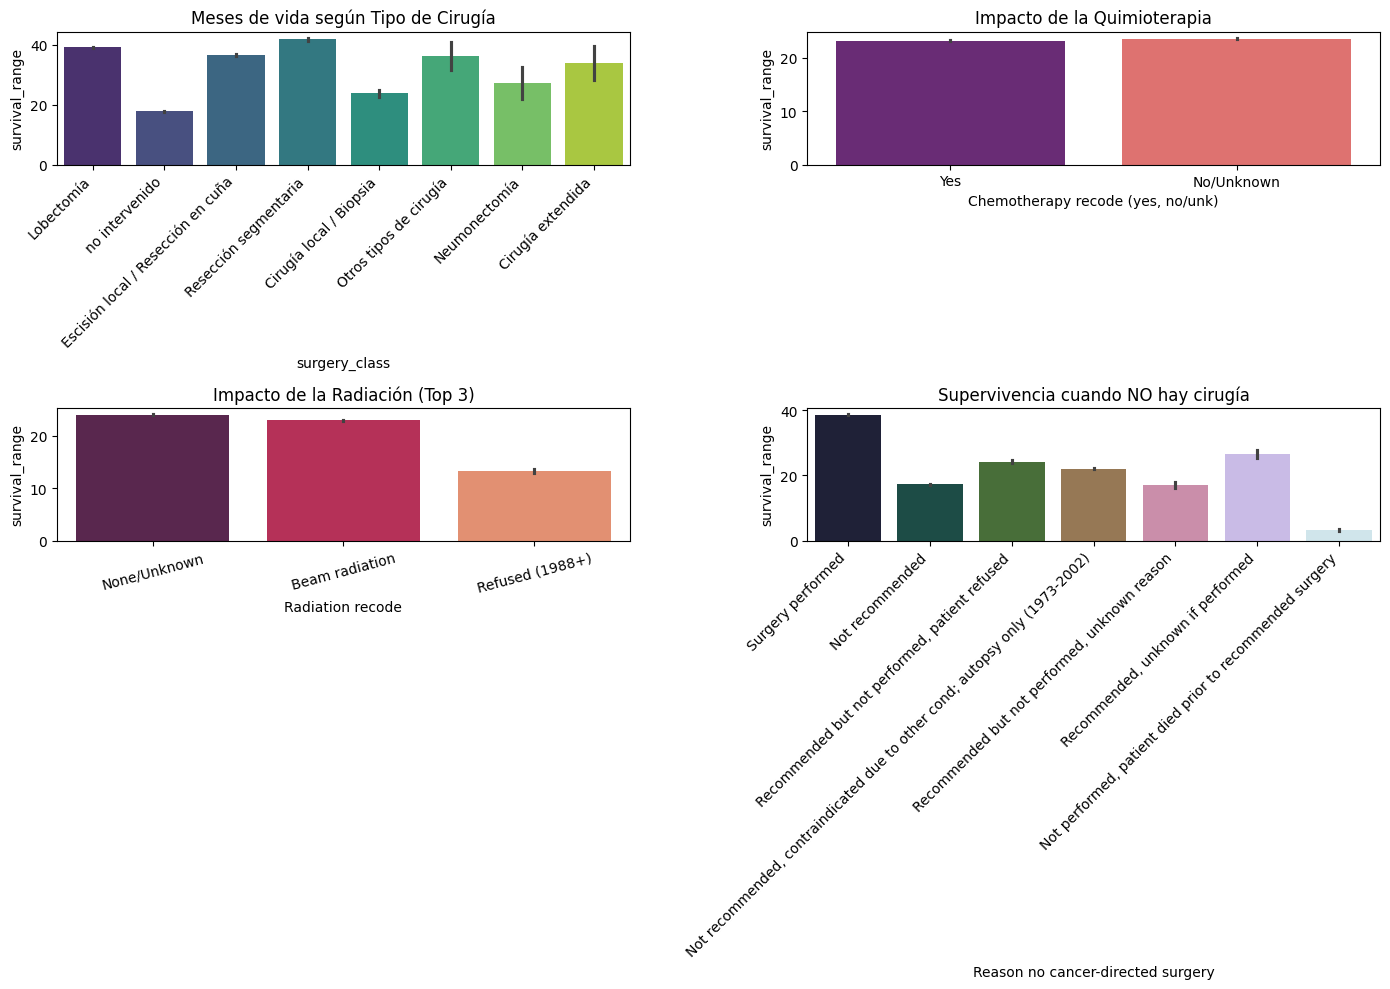

In [402]:


# Configuramos el estilo
plt.figure(figsize=(14, 10))

# 1. Gráfico de Supervivencia según el tipo de Cirugía (surgery_class)
plt.subplot(2, 2, 1)
sns.barplot(data=df, x='surgery_class', y='survival_range', palette='viridis')
plt.title('Meses de vida según Tipo de Cirugía')
plt.xticks(rotation=45, ha='right')

# 2. Gráfico según Quimioterapia (Chemo)
plt.subplot(2, 2, 2)
sns.barplot(data=df, x='Chemotherapy recode (yes, no/unk)', y='survival_range', palette='magma')
plt.title('Impacto de la Quimioterapia')

# 3. Gráfico según Radiación (simplificado para la gráfica)
plt.subplot(2, 2, 3)
# Filtramos solo los más comunes para no saturar
top_rad = df['Radiation recode'].value_counts().nlargest(3).index
sns.barplot(data=df[df['Radiation recode'].isin(top_rad)], x='Radiation recode', y='survival_range', palette='rocket')
plt.title('Impacto de la Radiación (Top 3)')
plt.xticks(rotation=15)

# 4. Gráfico según Razón de no cirugía
plt.subplot(2, 2, 4)
sns.barplot(data=df, x='Reason no cancer-directed surgery', y='survival_range', palette='cubehelix')
plt.title('Supervivencia cuando NO hay cirugía')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [403]:
df = df.drop(["Survival months flag", "survival_months_int"], axis=1)

In [404]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396263 entries, 0 to 450541
Data columns (total 21 columns):
 #   Column                                                Non-Null Count   Dtype   
---  ------                                                --------------   -----   
 0   Race                                                  396263 non-null  object  
 1   Primary Site                                          396263 non-null  object  
 2   vital_status                                          396263 non-null  object  
 3   Year of diagnosis                                     396263 non-null  int64   
 4   Radiation recode                                      396263 non-null  object  
 5   Chemotherapy recode (yes, no/unk)                     396263 non-null  object  
 6   Sex                                                   396263 non-null  object  
 7   Rural Code                                            396263 non-null  object  
 8   Reason no cancer-directed surgery      

In [405]:
df['grade_clinical'] = df['grade_clinical'].astype(str)
df['grade_clinical'].dtype

dtype('O')

### Crear una variable que combine la Cirugía con el Estadio del cáncer.
> - No es lo mismo un paciente en Stage I con cirugía que uno en Stage IV con cirugía.

In [406]:
# Forzamos la conversión a string antes de concatenar
df['Surgery_Stage'] = df['Reason no cancer-directed surgery'].astype(str) + "_" + df['Stage_Final'].astype(str)

# Verifica que se haya creado bien
print(df['Surgery_Stage'].unique()[:5])

['Surgery performed_Stage I' 'Not recommended_Stage IV'
 'Surgery performed_Stage II' 'Not recommended_Stage I'
 'Not recommended_Stage III']


## Crear una variable: Grupo de Riesgo por edadades.

In [407]:
df["age_group"].value_counts()

age_group
4    195612
5    139749
3     58795
2      1973
1       134
Name: count, dtype: int64

In [408]:
# Definimos los cortes (bins) y las etiquetas
# 0-2 (Bajo), 2-4 (Moderado), 5 (Alto)
bins = [0, 2, 4, 5]
labels = ['Bajo Riesgo', 'Moderado', 'Alto Riesgo']

# Creamos la columna
df['age_risk_group'] = pd.cut(df['age_group'], bins=bins, labels=labels)

# Verificamos la distribución
print(df['age_risk_group'].value_counts())

age_risk_group
Moderado       254407
Alto Riesgo    139749
Bajo Riesgo      2107
Name: count, dtype: int64


In [409]:
# Lista de columnas que claramente son categóricas en tu imagen
cols_categoricas = [
    'Race', 'Primary Site', 'vital_status', 'Radiation recode', 'Chemotherapy recode (yes, no/unk)', 'Sex', 'Rural Code', 'Reason no cancer-directed surgery',
    'Sequence number','histology_type_named', 'surgery_class', 'Stage_Final','grade_clinical', 'tratamiento', 'Surgery_Stage', 'age_risk_group'
]

# Convertir a category de un solo golpe
for col in cols_categoricas:
    df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396263 entries, 0 to 450541
Data columns (total 23 columns):
 #   Column                                                Non-Null Count   Dtype   
---  ------                                                --------------   -----   
 0   Race                                                  396263 non-null  category
 1   Primary Site                                          396263 non-null  category
 2   vital_status                                          396263 non-null  category
 3   Year of diagnosis                                     396263 non-null  int64   
 4   Radiation recode                                      396263 non-null  category
 5   Chemotherapy recode (yes, no/unk)                     396263 non-null  category
 6   Sex                                                   396263 non-null  category
 7   Rural Code                                            396263 non-null  category
 8   Reason no cancer-directed surgery      

## Preprocesamiento de Datos: Codificación Categórica y Feature Engineering

In [410]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# --- NUEVO: Limpiamos la lista de categorías ---
# Eliminamos 'vital_status' de la lista de columnas que el transformador espera encontrar
cols_categoricas_limpias = [c for c in cols_categoricas if c != 'vital_status']

# 1. Definimos el transformador (Usando la lista limpia)
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cols_categoricas_limpias)
    ],
    remainder='passthrough' 
)

# 2. Separamos Target de Features
# Aquí ya lo tenías bien, eliminando la fuga de datos
X = df.drop(columns=['survival_range', 'vital_status'])
y = df['survival_range']

# 3. Ajustamos y transformamos
# Ahora sí coinciden las columnas de X con lo que espera el transformador
X_processed = column_transformer.fit_transform(X)

# 4. Recuperamos los nombres y creamos el DF final
column_names = column_transformer.get_feature_names_out()
df_final = pd.DataFrame(X_processed, columns=column_names)

print(f"Forma final del dataset: {df_final.shape}")
print("✅ Procesamiento completado sin fuga de datos.")

Forma final del dataset: (396263, 104)
✅ Procesamiento completado sin fuga de datos.


## Split

In [411]:
from sklearn.model_selection import train_test_split

# Separamos el 80% para entrenar y el 20% para la prueba final
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

print(f"Entrenamiento: {X_train.shape[0]} registros")
print(f"Prueba: {X_test.shape[0]} registros")

Entrenamiento: 317010 registros
Prueba: 79253 registros


### Entrenamiento con Target Logarítmico y Pesos

> - el logaritmo corrige el sesgo (optimismo/pesimismo) y los pesos obligan al modelo a ser un "especialista" en el rango de los 60 meses.

In [412]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Transformación Logarítmica del Target
# Usamos log1p para transformar los meses reales a una escala proporcional
y_train_log = np.log1p(y_train)

# 2. Definición de Pesos para tu meta de 5 años (60 meses)
# Mantenemos los pesos para que el modelo preste doble atención a este rango crítico
# Nota: Los pesos se calculan sobre los datos originales (y_train), no sobre el log
pesos = np.where((y_train >= 48) & (y_train <= 72), 2.0, 1.0)

# 3. Configuración profesional del modelo
# Usamos 'reg:absoluteerror' para que el modelo minimice el MAE en escala logarítmica
model = xgb.XGBRegressor(
    n_estimators=1000,       # Aumentamos a 1000 para compensar la nueva complejidad
    objective='reg:absoluteerror',
    learning_rate=0.03,      # Bajamos un poco para una convergencia más fina
    max_depth=8,             # Mantenemos profundidad para captar 'Surgery_Stage'
    subsample=0.8,
    colsample_bytree=0.8,    # Regularización adicional
    n_jobs=-1,
    random_state=42,
    tree_method='hist'       # Recomendado para datasets grandes
)

# 4. Entrenamiento con Target Logarítmico y Pesos
model.fit(X_train, y_train_log, sample_weight=pesos)

# 5. Predicción y Reversión
# El modelo predice en log, así que aplicamos expm1 para volver a "Meses Reales"
y_pred_log = model.predict(X_test)
y_pred_final = np.expm1(y_pred_log)

# 6. Evaluación de resultados reales
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print(f"--- RESULTADOS CON TRANSFORMACIÓN LOG Y PESOS ---")
print(f"MAE Global: {mae_final:.2f} meses")
print(f"R2 Score: {r2_final:.4f}")

# 7. Verificación de tu meta de 5 años
mask_60m = (y_test >= 54) & (y_test <= 66)
if mask_60m.any():
    mae_60m = mean_absolute_error(y_test[mask_60m], y_pred_final[mask_60m])
    print(f"MAE específico en rango 5 años: {mae_60m:.2f} meses")

--- RESULTADOS CON TRANSFORMACIÓN LOG Y PESOS ---
MAE Global: 9.26 meses
R2 Score: 0.4714
MAE específico en rango 5 años: 10.30 meses


In [413]:
# import xgboost as xgb
# from sklearn.metrics import mean_absolute_error, r2_score

# # Configuración profesional del modelo
# model = xgb.XGBRegressor(
#     n_estimators=500,        # Número de árboles
#     objective='reg:absoluteerror',
#     learning_rate=0.05,      # Paso de aprendizaje (más bajo es más preciso pero lento)
#     max_depth=8,             # Profundidad de los árboles para captar interacciones
#     subsample=0.8,           # Usa el 80% de los datos por árbol para evitar sobreajuste
#     n_jobs=-1,               # Usa todos los núcleos de tu procesador
#     random_state=42
# )

# # Creamos un vector de pesos
# # Le damos más importancia (ej. doble) a los pacientes que vivieron entre 48 y 72 meses
# pesos = np.where((y_train >= 48) & (y_train <= 72), 2.0, 1.0)

# # Entrenamos pasando estos pesos
# model.fit(X_train, y_train, sample_weight=pesos)
# # Entrenamiento
# model.fit(X_train, y_train)

## MAE por cuantos meses se equivoca el modelo

In [414]:
# Predicciones Estandares
preds = model.predict(X_test)

# Métricas
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"Error Promedio (MAE): {mae:.2f} meses")
print(f"Precisión (R2 Score): {r2:.4f}")

Error Promedio (MAE): 20.82 meses
Precisión (R2 Score): -0.9514


In [415]:
# 1. Predicción (sale en escala logarítmica: 0 a 5 aprox)
y_pred_log = model.predict(X_test)

# 2. REVERSIÓN (Crucial para métricas reales)
# Pasamos de logaritmo a meses reales (0 a 100+ meses)
y_pred_final = np.expm1(y_pred_log)

# 3. EVALUACIÓN (Comparamos meses reales vs meses reales)
# Usamos y_test (original) NO y_test_log
mae = mean_absolute_error(y_test, y_pred_final)
r2 = r2_score(y_test, y_pred_final)

print(f"MAE Real: {mae:.2f} meses")
print(f"R2 Score Real: {r2:.4f}")

MAE Real: 9.26 meses
R2 Score Real: 0.4714


### métrica específica para  "target"

In [416]:
# Filtrar solo el grupo de interés en el set de prueba
mask_5years = (y_test >= 54) & (y_test <= 66) # Rango de 5 años +/- 6 meses
mae_5years = mean_absolute_error(y_test[mask_5years], preds[mask_5years])

print(f"Error promedio específicamente en pacientes de ~5 años: {mae_5years:.2f} meses")

Error promedio específicamente en pacientes de ~5 años: 55.27 meses


## Importancia de las características

In [417]:
import matplotlib.pyplot as plt
import pandas as pd

# Entrenamos el modelo (asumiendo que ya tienes X_train e y_train del paso anterior)
model.fit(X_train, y_train)

# Extraemos la importancia de las variables
importances = model.feature_importances_
feature_names = column_transformer.get_feature_names_out()

# Creamos un DataFrame para visualizarlo mejor
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Mostramos las top 15 variables más influyentes
print(feature_importance_df.head(15))

                                              Feature  Importance
24  cat__Reason no cancer-directed surgery_Surgery...    0.175044
54                  cat__surgery_class_no intervenido    0.159972
57                          cat__Stage_Final_Stage IV    0.139366
64                       cat__tratamiento_N + nQ + nR    0.101375
79        cat__Surgery_Stage_Not recommended_Stage IV    0.099466
13         cat__Chemotherapy recode (yes, no/unk)_Yes    0.063013
92       cat__Surgery_Stage_Surgery performed_Stage I    0.052811
63                        cat__tratamiento_N + nQ + R    0.018241
98                       remainder__Year of diagnosis    0.015371
46     cat__histology_type_named_Small Cell Carcinoma    0.011470
68                       cat__tratamiento_S + nQ + nR    0.010909
45                cat__histology_type_named_Other/NOS    0.009309
76         cat__Surgery_Stage_Not recommended_Stage I    0.006188
19  cat__Reason no cancer-directed surgery_Not rec...    0.005498
29    cat_

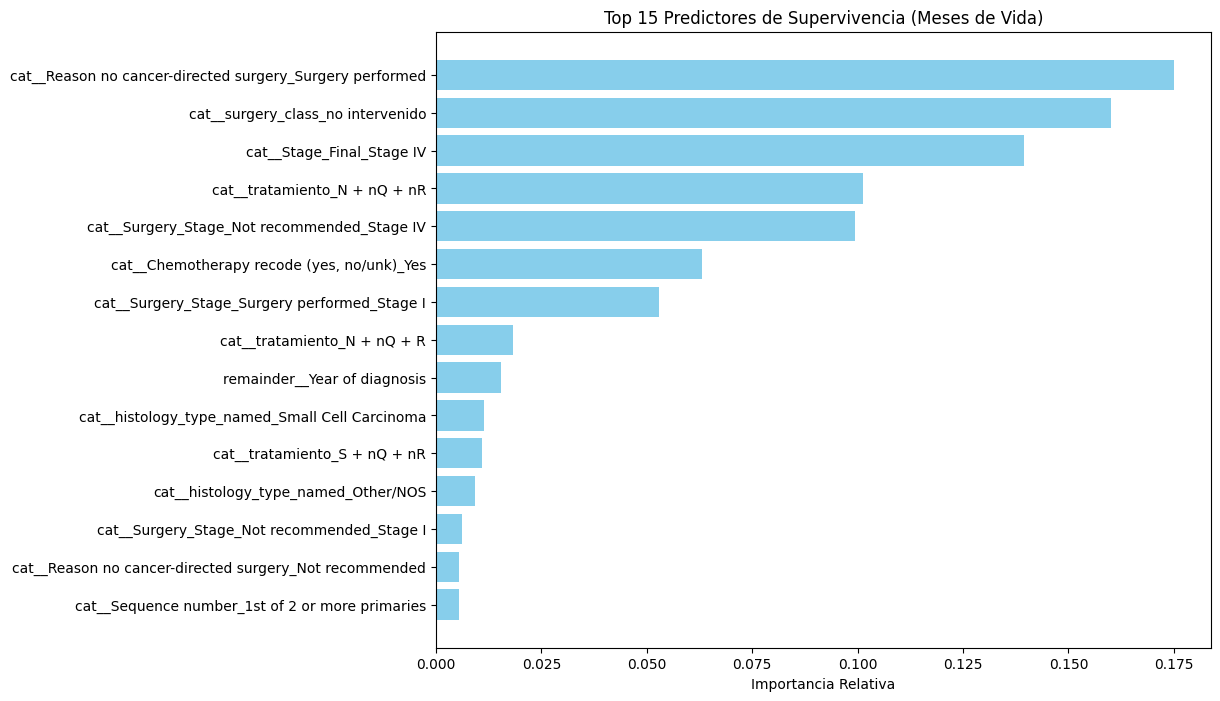

In [418]:
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'].head(15), feature_importance_df['Importance'].head(15), color='skyblue')
plt.xlabel('Importancia Relativa')
plt.title('Top 15 Predictores de Supervivencia (Meses de Vida)')
plt.gca().invert_yaxis() # Para que la más importante salga arriba
plt.show()

## Hiperparametrización, GPU AMD


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# 1. Configuración actualizada para XGBoost 3.1+ 
# En lugar de gpu_id, usamos 'device'
xgb_reg = xgb.XGBRegressor(
    objective='reg:absoluteerror', # Enfocado directamente en bajar el MAE
    tree_method='hist',     # 'hist' es el método estándar ahora para grandes datos
    device='cpu',          # ¡Ojo aquí! Aunque seas AMD, XGBoost usa 'cuda' como alias genérico 
                            # o 'cpu'. Si 'cuda' falla por drivers, usa 'cpu' con n_jobs=-1.
    n_jobs=-1
)

# Nota: Si estás en Windows con AMD, la forma más robusta de usar la GPU es:
# device='cpu' (XGBoost en Windows a veces tiene conflictos con AMD Radeon directas)
# Pero probemos primero con la configuración de alto rendimiento:

param_dist = {
    'n_estimators': [1000, 2000, 3000], 
    'max_depth': [8, 12],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8],
    'gamma': [0, 0.5, 1]
}

random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_dist,
    n_iter=20, # Reducimos un poco para probar que no truene
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=3,
    n_jobs=1 # La GPU ya paraleliza, no necesitamos n_jobs en el CV
)

# 2. Ejecutar de nuevo
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=1.0;, score=-9.151 total time=  30.2s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=1.0;, score=-9.122 total time=  30.9s
[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=1.0;, score=-9.091 total time=  29.8s
[CV 1/3] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=12, n_estimators=3000, subsample=1.0;, score=-9.225 total time= 2.6min
[CV 2/3] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=12, n_estimators=3000, subsample=1.0;, score=-9.189 total time= 2.6min
[CV 3/3] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=12, n_estimators=3000, subsample=1.0;, score=-9.175 total time= 2.7min
[CV 1/3] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_dept

## Guardar el mejor modelo.

In [ ]:
# Extraemos el mejor modelo de la búsqueda
mejor_modelo = random_search.best_estimator_

# Guardar en formato JSON (recomendado para XGBoost moderno)
mejor_modelo.save_model('../models/mejormodelo_xgb_supervivencia.json')

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Realizar predicciones
y_pred = mejor_modelo.predict(X_test)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"--- RENDIMIENTO DEL MODELO ---")
print(f"Error Promedio (MAE): {mae:.2f} meses")
print(f"Precisión (R2 Score): {r2:.4f}")

--- RENDIMIENTO DEL MODELO ---
Error Promedio (MAE): 9.06 meses
Precisión (R2 Score): 0.5015


## Análisis de Residuos (¿Dónde fallamos?)
Antes de tocar el código, necesitamos saber si el modelo falla por igual en todos los pacientes o si se equivoca más con los que viven mucho tiempo (outliers).

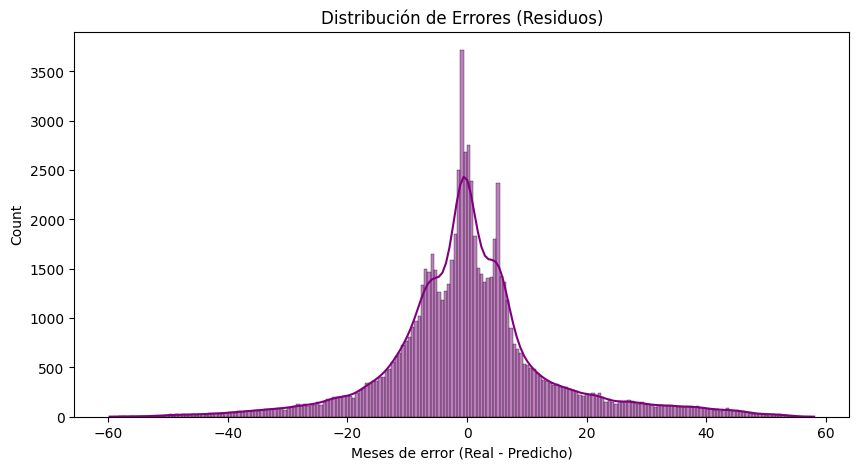

In [ ]:
# Graficar errores
residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Distribución de Errores (Residuos)')
plt.xlabel('Meses de error (Real - Predicho)')
plt.show()

### Observaciones:
> - La distribución tiene una forma de campana (gaussiana) casi perfecta y centrada en cero, significa que el modelo no tiene un sesgo sistemático (no tiende a sobreestimar ni subestimar de forma generalizada).
> - La "Leptocurtosis" (Pico alto): Tiene una gran concentración de errores muy cerca de cero. Para la gran mayoría de los pacientes, el modelo es extremadamente preciso.
> - Las colas largas (Outliers): El gráfico se extiende hasta -60 y +60 meses. Estos son pacientes cuya supervivencia fue muy distinta a la media (casos excepcionales o milagrosos en términos médicos).

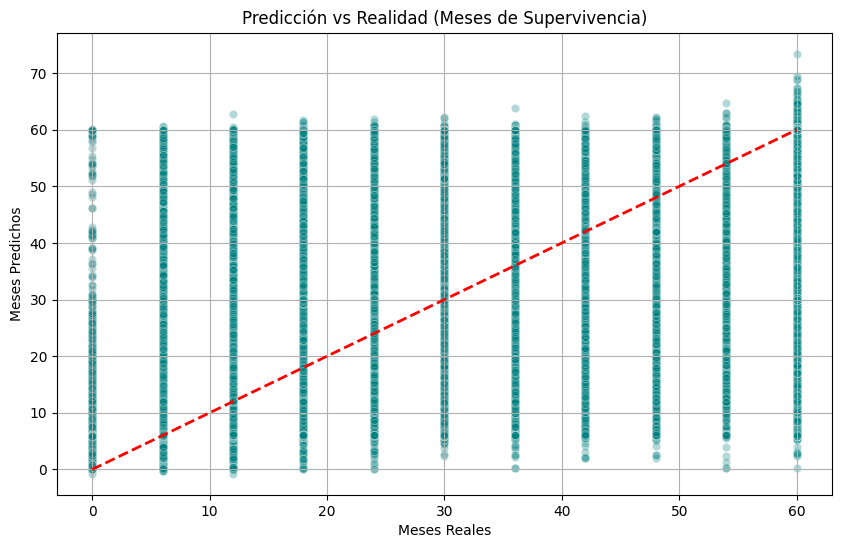

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')
plt.title('Predicción vs Realidad (Meses de Supervivencia)')
plt.xlabel('Meses Reales')
plt.ylabel('Meses Predichos')
plt.grid(True)
plt.show()

## Combinar  de XGBoost con la de LightGBM

In [ ]:
from sklearn.ensemble import VotingRegressor
import lightgbm as lgb

# Usamos los mejores parámetros que ya encontraste para XGB
model_xgb = random_search.best_estimator_

# Definimos un LightGBM rápido
model_lgb = lgb.LGBMRegressor(n_estimators=2000, learning_rate=0.05, device="cpu")

# Los combinamos
ensemble = VotingRegressor(estimators=[('xgb', model_xgb), ('lgb', model_lgb)])
ensemble.fit(X_train, y_train)

c:\Users\Usuario\miniconda3\envs\env_312project\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:05:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Usuario\miniconda3\envs\env_312project\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:05:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 317010, number of used features: 94
[LightGBM] [Info] Start training from score 23.357036


,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingRegressor`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('xgb', ...), ('lgb', ...)]"
,"weights weights: array-like of shape (n_regressors,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted values before averaging. Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:absoluteerror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8


In [ ]:
from sklearn import metrics
import numpy as np

# 1. Generar predicciones si no las tienes
y_pred = ensemble.predict(X_test)

# 2. Calcular métricas
r2 = metrics.r2_score(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"--- Métricas del Modelo Ensemble ---")
print(f"R² (Coeficiente de determinación): {r2:.4f}")
print(f"MAE (Error Absoluto Medio): {mae:.4f} meses")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f} meses")

c:\Users\Usuario\miniconda3\envs\env_312project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


--- Métricas del Modelo Ensemble ---
R² (Coeficiente de determinación): 0.5422
MAE (Error Absoluto Medio): 9.3885 meses
RMSE (Raíz del Error Cuadrático Medio): 13.8223 meses
